# Multi-class Substructure Classification

<u>Dataset Used</u>: https://drive.google.com/file/d/1B_UZtU4W65ZViTJsLeFfvK-xXCYUhw2A/view

<u>Evaluation Metrics</u>: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve).

<u>Approach Used</u>: Train and evaluate the performance of different CNNs, ViTs, and Ensembles. Combine (average) the predictions of all the models to provide the best results.

# 1. Imports

In [ ]:
import os
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import platform
from tqdm import tqdm
import random
import glob
import copy
from dataclasses import dataclass
import time
from collections import Counter
from collections import defaultdict
import gc

import sklearn
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.nn.functional as nnf

import timm
import cv2

import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Check for GPU availability

In [ ]:
!nvidia-smi

Wed Mar  8 07:58:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Define a `CONFIG` class containing different hyperparameters for our models, set a common random seed and use the `DEVICE` (GPU) to train the models.

In [ ]:
@dataclass
class CONFIG:
    TRAIN_PATH = "/kaggle/input/gsoc-deep-lense-task-1/dataset/train"
    VAL_PATH = "/kaggle/input/gsoc-deep-lense-task-1/dataset/val"
    MODEL_NAMES = ['densenet161', 'mobilevitv2_150', 'mobilevitv2_150_384_in22ft1k']
    BATCH_SIZE = 32
    LEARNING_RATE = 1e-4
    DROPOUT = 0.3
    EPOCHS = 10

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def get_device():
    global DEVICE
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device("cuda:0")
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        DEVICE = torch.device("cpu")
    
RANDOM_SEED = 42
set_seed(RANDOM_SEED)
get_device()

[INFO] Using GPU: Tesla P100-PCIE-16GB



Get file paths for training and validation sets

In [ ]:
train_image_paths = []
val_image_paths = []
classes = []

for train_data_path in glob.glob(CONFIG.TRAIN_PATH + "/*"):
    classes.append(train_data_path.split("/")[-1])
    train_image_paths.append(glob.glob(train_data_path + "/*"))
    
for val_data_path in glob.glob(CONFIG.VAL_PATH + "/*"):
    val_image_paths.append(glob.glob(val_data_path + "/*"))
    
# print(train_image_paths)
# print(classes)

train_image_paths = list(flatten(train_image_paths))
val_image_paths = list(flatten(val_image_paths))


# print(f"Train Image Path: {train_image_paths[0].split('/')[-2]}")
# print(f"Class: {classes[0]}")

print(f"Train Size: {len(train_image_paths)}\nVal Size: {len(val_image_paths)}")

Train Size: 30000
Val Size: 7500


Map indices to classes and vice-versa

In [ ]:
idx_to_class = {i: j for i, j in enumerate(classes)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

print(f"Index to class dictionary: {idx_to_class}")
print(f"Class to index dictionary: {class_to_idx}")

Index to class dictionary: {0: 'no', 1: 'vort', 2: 'sphere'}
Class to index dictionary: {'no': 0, 'vort': 1, 'sphere': 2}


# 2. Creating the Dataset

Create a custom dataset class `GSoCDeepLensePrivateDatasetTask1` for creating train and valid sets

In [ ]:
class GSoCDeepLensePrivateDatasetTask1(Dataset):
    
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = np.load(image_filepath)
        
        if(self.transform is not False):
            image = self.transform(image=image)["image"]
        
        label = image_filepath.split("/")[-2]
        label = class_to_idx[label]
            
        return image, label

train_dataset = GSoCDeepLensePrivateDatasetTask1(image_paths=train_image_paths, transform=False)
val_dataset = GSoCDeepLensePrivateDatasetTask1(image_paths=val_image_paths, transform=False)

# 3. Visualizing Images

Taking a look at the images present in the train and valid sets respectively

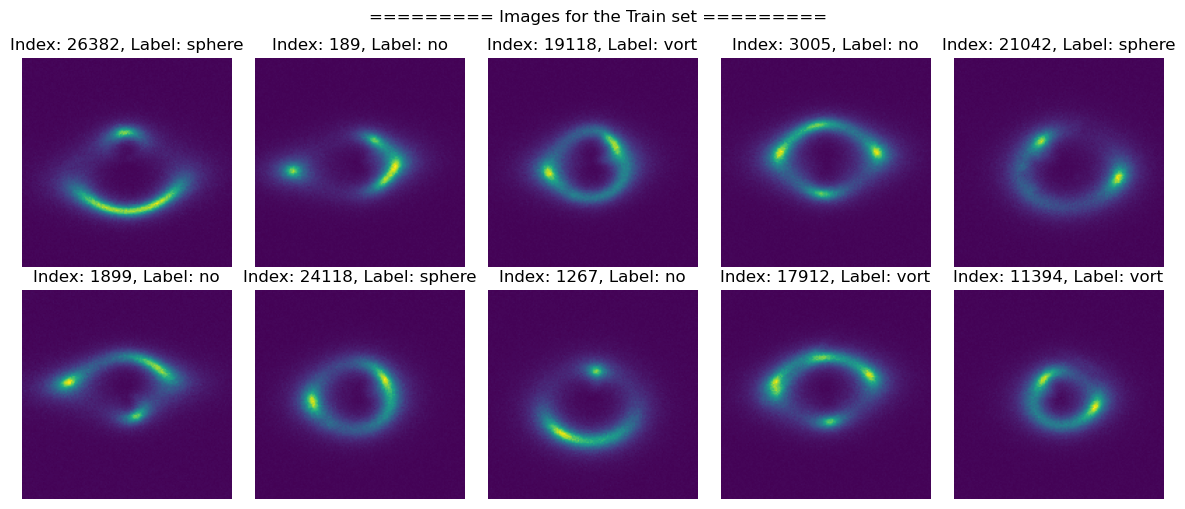

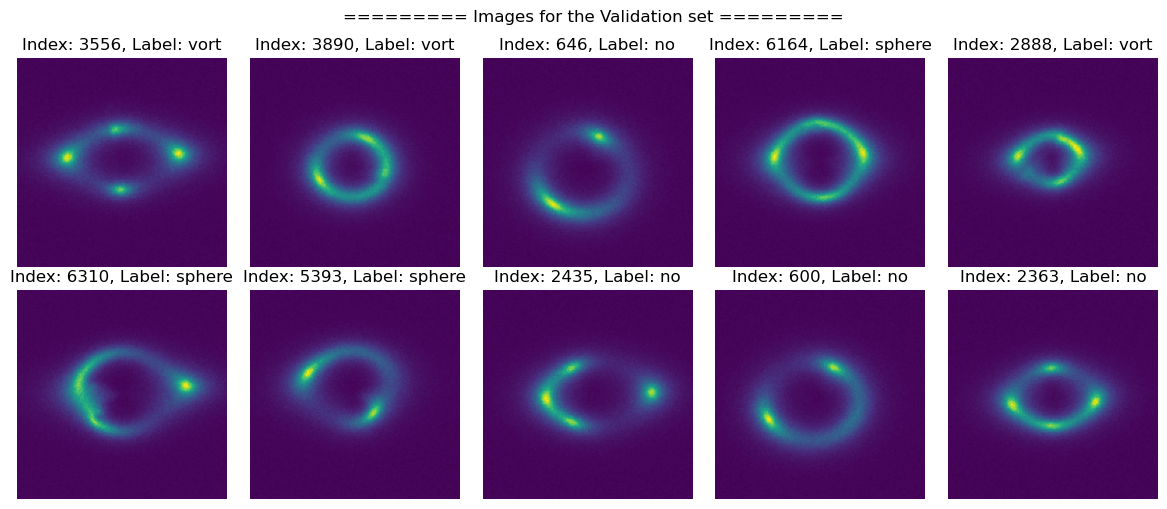

In [ ]:
def visualize_images(dataset_input, dataset_type, samples, cols):
    
    dataset_len = len(dataset_input)
    dataset = dataset_input
    
    rows = samples // cols
    
    fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12, 8))
    fig.suptitle(f"========= Images for the {dataset_type.title()} set =========", y=0.9)
    
    for i in range(samples):
        idx = np.random.randint(0, dataset_len)
        image, label = dataset[idx]
#         image = np.expand_dim(image, axis=0)
        image = image.swapaxes(0, 1)
        image = image.swapaxes(1, 2)
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(f"Index: {idx}, Label: {idx_to_class[label]}")
        
    plt.tight_layout(rect=[0, 0.2, 0.99, 0.975], h_pad=2.1, pad=1.7)
    plt.show()
    
visualize_images(dataset_input=train_dataset, dataset_type="train", samples=10, cols=5)
visualize_images(dataset_input=val_dataset, dataset_type="validation", samples=10, cols=5)

# 4. Creating Dataloaders

Creating train and valid dataloaders

In [ ]:
def make_data_loader(dataset, shuffle):
    loader = DataLoader(dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=shuffle)
    
    return loader

train_loader = make_data_loader(dataset=train_dataset, shuffle=True)
val_loader = make_data_loader(dataset=val_dataset, shuffle=False)

Creating custom model classes that inherit from `nn.Module`

In [ ]:
class TransferLearningModelOld(nn.Module):
    
    def __init__(self, n_classes):
        super(TransferLearningModelOld, self).__init__()
        self.transfer_learning_model = timm.create_model(CONFIG.MODEL_NAMES[0], pretrained=True, in_chans=1)
        
        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(2208 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.25),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
        x = x.view(-1, 2208 * 4 * 4)
        x = self.classifier(x)
        
        return x

class TransferLearningModelNew(nn.Module):
    
    def __init__(self, n_classes):
        super(TransferLearningModelNew, self).__init__()
        self.transfer_learning_model = timm.create_model(CONFIG.MODEL_NAMES[0], pretrained=True, in_chans=1)
        
        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(2208 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.33),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.33),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
        x = x.view(-1, 2208 * 4 * 4)
        x = self.classifier(x)
        
        return x

class DenseNet201(nn.Module):
    
    def __init__(self, n_classes):
        super(DenseNet201, self).__init__()
        self.transfer_learning_model = timm.create_model("densenet201", pretrained=True, in_chans=1)
        
        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(1920 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.33),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.33),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
#         print(x.shape)
        x = x.view(-1, 1920 * 4 * 4)
        x = self.classifier(x)
        
        return x
    
class MobileVitV2_150(nn.Module):
    
    def __init__(self, n_classes):
        
        super(MobileVitV2_150, self).__init__()
        
        self.vit_model = timm.create_model(CONFIG.MODEL_NAMES[2], pretrained=True, in_chans=1)
        
        for param in self.vit_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(768 * 6 * 6, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.vit_model.forward_features(x)
#         print(x.shape)
        x = x.reshape(-1, 768 * 6 * 6)
        x = self.classifier(x)
        
        return x

# (test performance of an ensemble)
class DenseNetEnsemble(nn.Module):
    
    def __init__(self, n_classes, modela, modelb):
        
        super(DenseNetEnsemble, self).__init__()
        
        self.modela = modela
        self.modelb = modelb
        
    def forward(self, x):
        outa = self.modela(x)
        outb = self.modelb(x)
        out = outa + outb
        x = out
        
        return x

Since the latest training example was that of an ensemble model we initialize `model` as an instance of the `DenseNetEnsemble` class

In [ ]:
# model = MobileVitv2_150_384_in22ft1k(len(classes))
# model = model.to(DEVICE)

modela = TransferLearningModelNew(len(classes))
modela = modela.to(DEVICE)

modelb = DenseNet201(len(classes))
modelb = modelb.to(DEVICE)

model = DenseNetEnsemble(len(classes), modela, modelb)
model = model.to(DEVICE)
# x = torch.randn(32,1,150,150).to(DEVICE)
# model(x).shape

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


Trains the model for 1 epoch

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    
    model.train()
    
    total = 0
    correct = 0
    train_accuracy = []
    train_loss = []
    
    for i, data in enumerate(tqdm(data_loader)):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        y_pred = model(images.float())
        loss = criterion(y_pred, labels)
        
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if(i % 10 == 0):
            print(f"Loss: {loss}, Accuracy: {accuracy}")
        
        train_accuracy.append(torch.tensor(accuracy))
        train_loss.append(torch.tensor(loss))
        
    return train_accuracy, train_loss

Tests the performance of the trained model

In [ ]:
def test_model(model, data_loader, device):
    
    model.eval()
    
    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
        
            y_pred = model(images.float())
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            
            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))
                    
    return val_accuracy, val_loss

Converts tensor-lists to numpy arrays and computes the mean value

In [ ]:
def convert_tensor_list_to_single_mean_value(tensor_list):

    tensor_list = [tensor.detach().cpu().numpy() for tensor in tensor_list]
    
    return np.mean(tensor_list)

Criterion and optimizer used to train the model

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

# 5. Training the Model

Cell commented out to save GPU time

In [ ]:
# %%time

# history = defaultdict(list)
# best_accuracy = 0
# model_name = "ensemble"

# for epoch in range(CONFIG.EPOCHS):
#     print(f"Epoch {epoch + 1} / {CONFIG.EPOCHS}")
#     print('=' * 10)
    
#     train_accuracy, train_loss = train_one_epoch(model=model, optimizer=optimizer, data_loader=train_loader, device=DEVICE)
#     train_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=train_accuracy)
#     train_loss = convert_tensor_list_to_single_mean_value(tensor_list=train_loss)
#     print(f'Train loss: {train_loss}\nTrain accuracy: {train_accuracy}\n')
    
#     val_accuracy, val_loss = test_model(model=model, data_loader=val_loader, device=DEVICE)
#     val_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=val_accuracy)
#     val_loss = convert_tensor_list_to_single_mean_value(tensor_list=val_loss)
#     print(f'Val loss: {val_loss}\nVal accuracy: {val_accuracy}\n')
    
#     history['train_acc'].append(train_accuracy)
#     history['train_loss'].append(train_loss)
#     history['val_acc'].append(val_accuracy)
#     history['val_loss'].append(val_loss) 
    
#     if(val_accuracy > best_accuracy):
#         torch.save(model.state_dict(), 
#                    f'{model_name}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.bin')
#         best_accuracy = val_accuracy

# 6. Visualizing Model Performance of a trained model


In [ ]:
# def generate_acc_loss_plots(history):
    
#     ax = plt.figure().gca()
#     plt.plot(history['train_acc'], label='train accuracy')
#     plt.plot(history['val_acc'], label='validation accuracy')
#     plt.title('Model Accuracy')
#     plt.ylabel('Accuracy')
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.show()
    
#     ax = plt.figure().gca()
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
#     plt.plot(history['train_loss'], label='Training Loss')
#     plt.plot(history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend()
#     plt.ylim([0, 1])
#     plt.show()
    
# generate_acc_loss_plots(history)

Reduce memory usage by deleting all redundant variables

In [ ]:
# del model, train_loader, history
# gc.collect()

Loading all the previously trained models. In case evaluation is to be done for a single model, all the lines need to be commented out, except for the last 3. Otherwise, all the models trained will be loaded.

In [ ]:
model1 = TransferLearningModelOld(len(classes))
model1 = model1.to(DEVICE)
model1.load_state_dict(torch.load('/kaggle/input/gsoc-task-1-models/densenet161_epochs_2_batchsize_64_lr_0.0001.bin'))

model2 = TransferLearningModelOld(len(classes))
model2 = model2.to(DEVICE)
model2.load_state_dict(torch.load('/kaggle/input/gsoc-task-1-models/densenet161_epochs_6_batchsize_64_lr_0.0001.bin'))

model3 = TransferLearningModelNew(len(classes))
model3 = model3.to(DEVICE)
model3.load_state_dict(torch.load(f'/kaggle/input/gsoc-task-1-models/densenet161_epochs_15_batchsize_64_lr_0.0001.bin'))

model4 = MobileVitV2_150(len(classes))
model4 = model4.to(DEVICE)
model4.load_state_dict(torch.load('/kaggle/input/gsoc-task-1-models/mobilevitv2_150_epochs_15_batchsize_32_lr_0.0001.bin'))

model5 = DenseNet201(len(classes))
model5 = model5.to(DEVICE)
model5.load_state_dict(torch.load('/kaggle/input/gsoc-task-1-models/densenet201_epochs_15_batchsize_64_lr_0.0001.bin'))

model6 = DenseNetEnsemble(len(classes),
                          TransferLearningModelNew(len(classes)).to(DEVICE),
                          DenseNet201(len(classes)).to(DEVICE)
                         )
model6 = model6.to(DEVICE)
model6.load_state_dict(torch.load('/kaggle/input/gsoc-task-1-models/ensemble_epochs_10_batchsize_32_lr_0.0001.bin'))

# model = DenseNetEnsemble(len(classes), modela, modelb)
# model = model.to(DEVICE)
# model.load_state_dict(torch.load(f'/kaggle/working/{model_name}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.bin'))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-mvit-weights/mobilevitv2_150_384_in22ft1k-9e142854.pth" to /root/.cache/torch/hub/checkpoints/mobilevitv2_150_384_in22ft1k-9e142854.pth


<All keys matched successfully>

# 7. Model Predictions

In [ ]:
def get_model_predictions(model, data_loader, device):
    
    model.eval()
    
    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []
    y_test_all = []
    y_pred_all = []
    y_pred_prob_all = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            y_test_all.append(labels)
        
            y_pred = model(images.float())
#             print("y_pred:", y_pred, y_pred.shape)
            prob = nnf.softmax(y_pred, dim=1)
#             print("prob:", prob, prob.shape)
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
#             print("predicted", predicted, predicted.shape)
            y_pred_prob_all.append(prob)
            y_pred_all.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            
            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))
                    
    return val_accuracy, val_loss, y_test_all, y_pred_all, y_pred_prob_all

test_accuracy1, test_loss1, y_test1, y_pred1, y_pred_prob1 = get_model_predictions(model=model1, data_loader=val_loader, device=DEVICE)
test_accuracy2, test_loss2, y_test2, y_pred2, y_pred_prob2 = get_model_predictions(model=model2, data_loader=val_loader, device=DEVICE)
test_accuracy3, test_loss3, y_test3, y_pred3, y_pred_prob3 = get_model_predictions(model=model3, data_loader=val_loader, device=DEVICE)
test_accuracy4, test_loss4, y_test4, y_pred4, y_pred_prob4 = get_model_predictions(model=model4, data_loader=val_loader, device=DEVICE)
test_accuracy5, test_loss5, y_test5, y_pred5, y_pred_prob5 = get_model_predictions(model=model5, data_loader=val_loader, device=DEVICE)
test_accuracy6, test_loss6, y_test6, y_pred6, y_pred_prob6 = get_model_predictions(model=model6, data_loader=val_loader, device=DEVICE)
# test_accuracy, test_loss, y_test, y_pred = get_model_predictions(model=model, data_loader=val_loader, device=DEVICE)

100%|██████████| 235/235 [00:39<00:00,  5.93it/s]


Flattens the `y_test` and `y_pred` arrays

In [ ]:
def get_flat_arrays(arrays):
    arrays = [tensor.detach().cpu().numpy() for tensor in arrays]
    arrays = np.concatenate(arrays)
    arrays = arrays.ravel()
    
    return arrays
    
y_test1 = get_flat_arrays(arrays=y_test1)
y_pred1 = get_flat_arrays(arrays=y_pred1)

y_test2 = get_flat_arrays(arrays=y_test2)
y_pred2 = get_flat_arrays(arrays=y_pred2)

y_test3 = get_flat_arrays(arrays=y_test3)
y_pred3 = get_flat_arrays(arrays=y_pred3)

y_test4 = get_flat_arrays(arrays=y_test4)
y_pred4 = get_flat_arrays(arrays=y_pred4)

y_test5 = get_flat_arrays(arrays=y_test5)
y_pred5 = get_flat_arrays(arrays=y_pred5)

y_test6 = get_flat_arrays(arrays=y_test6)
y_pred6 = get_flat_arrays(arrays=y_pred6)

# y_test = get_flat_arrays(arrays=y_test)
# y_pred = get_flat_arrays(arrays=y_pred)

# 8. Classification Reports and Confusion Matrices

Gives a better understanding about the performance of the models

========== For DenseNet161_Epochs_2 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2500
           1       0.91      0.86      0.88      2500
           2       0.87      0.83      0.85      2500

    accuracy                           0.88      7500
   macro avg       0.88      0.88      0.88      7500
weighted avg       0.88      0.88      0.88      7500



F1 Score: 0.8762505605380534
Precision: 0.8782716747585354
Recall: 0.8766666666666667




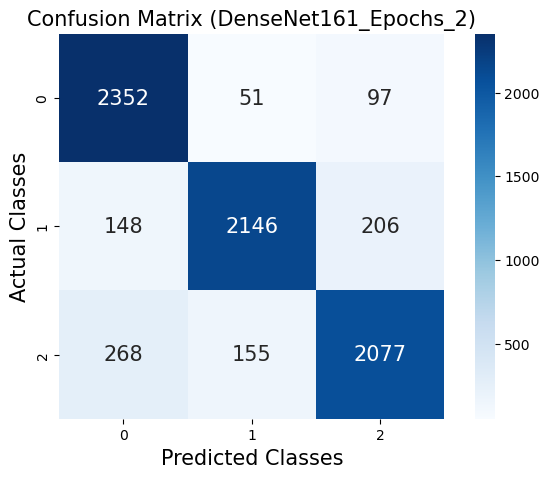



========== For DenseNet161_Epochs_6 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89      2500
           1       0.91      0.90      0.90      2500
           2       0.98      0.75      0.85      2500

    accuracy                           0.88      7500
   macro avg       0.89      0.88      0.88      7500
weighted avg       0.89      0.88      0.88      7500



F1 Score: 0.8783189685819346
Precision: 0.8941560547931736
Recall: 0.8798666666666667




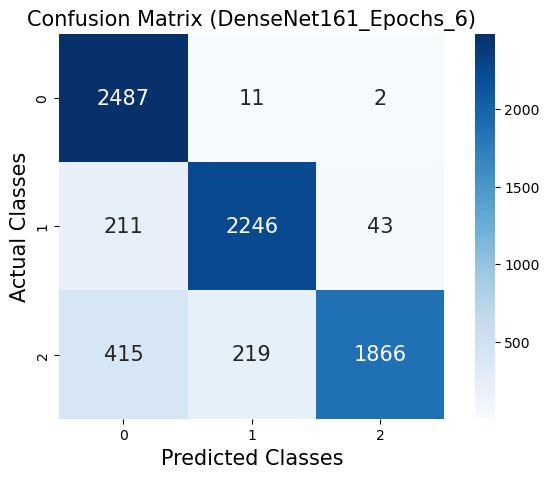



========== For DenseNet161_Epochs_15 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      2500
           1       0.95      0.90      0.92      2500
           2       0.93      0.83      0.88      2500

    accuracy                           0.90      7500
   macro avg       0.91      0.90      0.90      7500
weighted avg       0.91      0.90      0.90      7500



F1 Score: 0.903709559407565
Precision: 0.9091555802732263
Recall: 0.9041333333333333




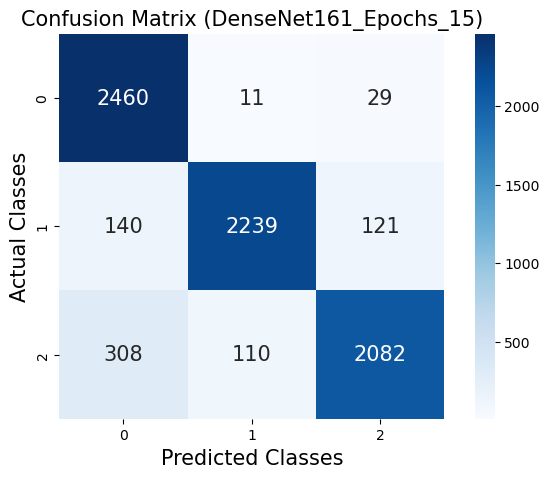



========== For MobileVitV2_150_Epochs_15 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      2500
           1       0.86      0.87      0.86      2500
           2       0.91      0.73      0.81      2500

    accuracy                           0.85      7500
   macro avg       0.86      0.85      0.85      7500
weighted avg       0.86      0.85      0.85      7500



F1 Score: 0.848463831441737
Precision: 0.8571673791829946
Recall: 0.8505333333333334




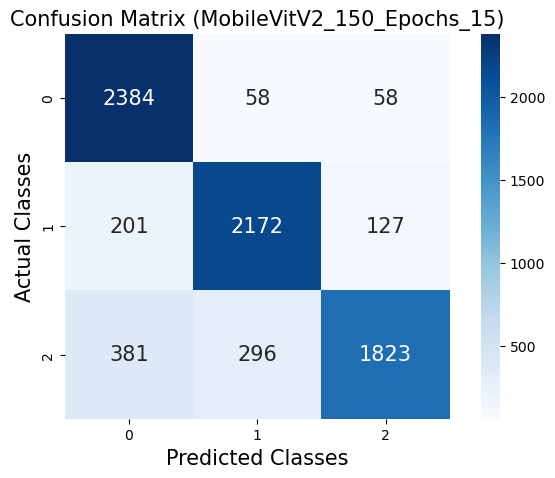



========== For DenseNet201_Epochs_15 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.91      2500
           1       0.88      0.92      0.90      2500
           2       0.96      0.76      0.85      2500

    accuracy                           0.89      7500
   macro avg       0.90      0.89      0.88      7500
weighted avg       0.90      0.89      0.88      7500



F1 Score: 0.8848673452580882
Precision: 0.895398417015275
Recall: 0.8869333333333334




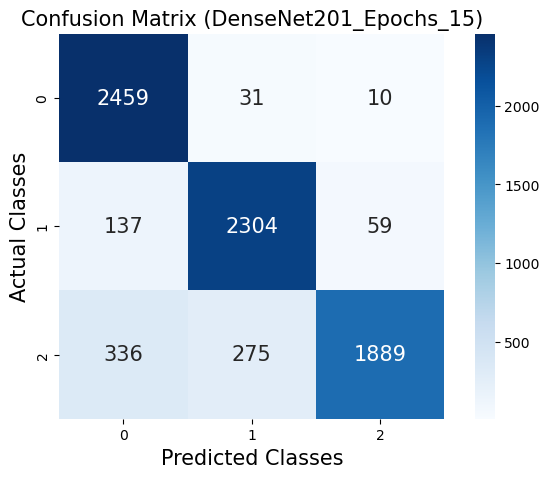



========== For Ensemble_DenseNet161_DenseNet201_Epochs_10 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93      2500
           1       0.94      0.91      0.93      2500
           2       0.93      0.86      0.89      2500

    accuracy                           0.92      7500
   macro avg       0.92      0.92      0.92      7500
weighted avg       0.92      0.92      0.92      7500



F1 Score: 0.9162345820870903
Precision: 0.9180528220440315
Recall: 0.9166666666666666




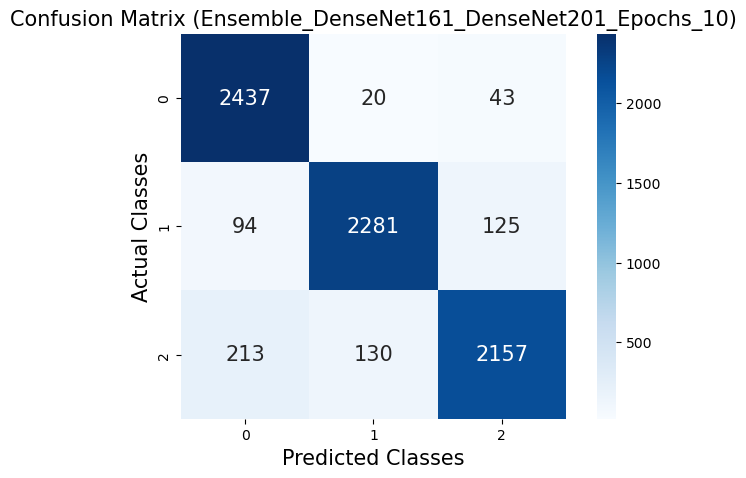

In [ ]:
def get_model_classification_report_and_confusion_matrix(model_name, y_test, y_pred):
    
    print("=" * 10, f"For {model_name}", "=" * 10)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")
    print(f"F1 Score: {f1_score(y_test, y_pred, average = 'weighted')}")
    print(f"Precision: {precision_score(y_test, y_pred, average = 'weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average = 'weighted')}")
    print("\n")
    plt.figure(figsize = (8, 5))
    ax = plt.axes()
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, fmt = "d", cmap = "Blues", cbar = True, annot_kws={'size': 15})
    ax.xaxis.set_tick_params(labelsize = 10)
    ax.yaxis.set_tick_params(labelsize = 10)
    plt.title(f"Confusion Matrix ({model_name})", fontsize = 15)
    plt.ylabel("Actual Classes", fontsize = 15)
    plt.xlabel("Predicted Classes", fontsize = 15)
    plt.show()
    print("\n")
    
get_model_classification_report_and_confusion_matrix("DenseNet161_Epochs_2", y_test1, y_pred1)
get_model_classification_report_and_confusion_matrix("DenseNet161_Epochs_6", y_test2, y_pred2)
get_model_classification_report_and_confusion_matrix("DenseNet161_Epochs_15", y_test3, y_pred3)
get_model_classification_report_and_confusion_matrix("MobileVitV2_150_Epochs_15", y_test4, y_pred4)
get_model_classification_report_and_confusion_matrix("DenseNet201_Epochs_15", y_test5, y_pred5)
get_model_classification_report_and_confusion_matrix("Ensemble_DenseNet161_DenseNet201_Epochs_10", y_test6, y_pred6)

One-hot encoding the arrays

In [ ]:
def one_hot_encode_array(array, num_classes):
    
    return np.squeeze(np.eye(num_classes)[array.reshape(-1)])

y_test1 = one_hot_encode_array(array=y_test1, num_classes=len(classes))
y_pred1 = one_hot_encode_array(array=y_pred1, num_classes=len(classes))

y_test2 = one_hot_encode_array(array=y_test2, num_classes=len(classes))
y_pred2 = one_hot_encode_array(array=y_pred2, num_classes=len(classes))

y_test3 = one_hot_encode_array(array=y_test3, num_classes=len(classes))
y_pred3 = one_hot_encode_array(array=y_pred3, num_classes=len(classes))

y_test4 = one_hot_encode_array(array=y_test4, num_classes=len(classes))
y_pred4 = one_hot_encode_array(array=y_pred4, num_classes=len(classes))

y_test5 = one_hot_encode_array(array=y_test5, num_classes=len(classes))
y_pred5 = one_hot_encode_array(array=y_pred5, num_classes=len(classes))

y_test6 = one_hot_encode_array(array=y_test6, num_classes=len(classes))
y_pred6 = one_hot_encode_array(array=y_pred6, num_classes=len(classes))

# y_test = one_hot_encode_array(array=y_test, num_classes=len(classes))
# y_pred = one_hot_encode_array(array=y_pred, num_classes=len(classes))

Converting the `y_pred_prob` array into the required format.

In [ ]:
def get_flattened_array(array):
    
    flattened_array = []
    
    for row in array:
        for col in row:
            flattened_array.append(col)
            
    return flattened_array

def get_required_array_format(array):
    
    array = get_flattened_array(array)
    array = [tensor.detach().cpu().numpy() for tensor in array]
    array = np.array(array)
    
    return array


y_pred_prob1 = get_required_array_format(y_pred_prob1)
y_pred_prob2 = get_required_array_format(y_pred_prob2)
y_pred_prob3 = get_required_array_format(y_pred_prob3)
y_pred_prob4 = get_required_array_format(y_pred_prob4)
y_pred_prob5 = get_required_array_format(y_pred_prob5)
y_pred_prob6 = get_required_array_format(y_pred_prob6)

# 9. ROC-AUC Curves of the trained models

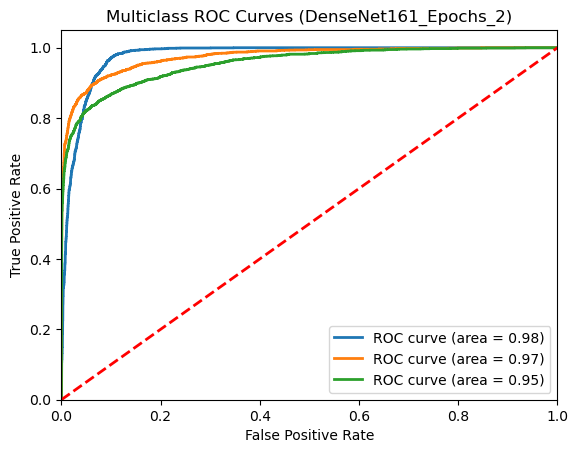

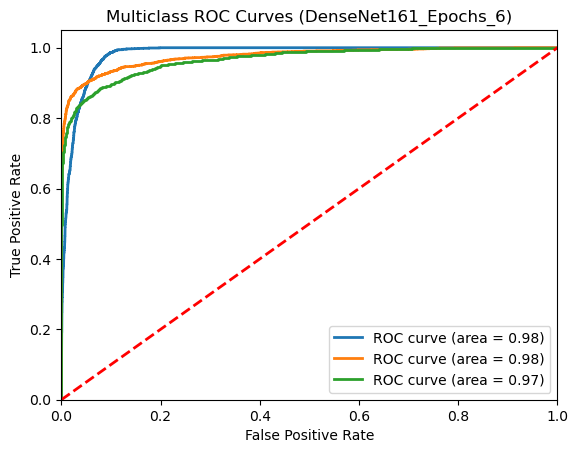

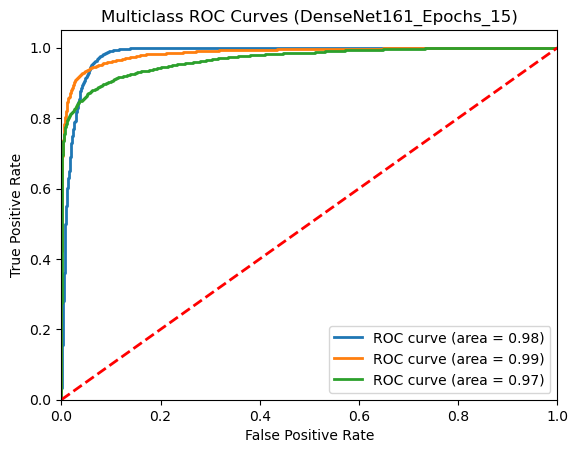

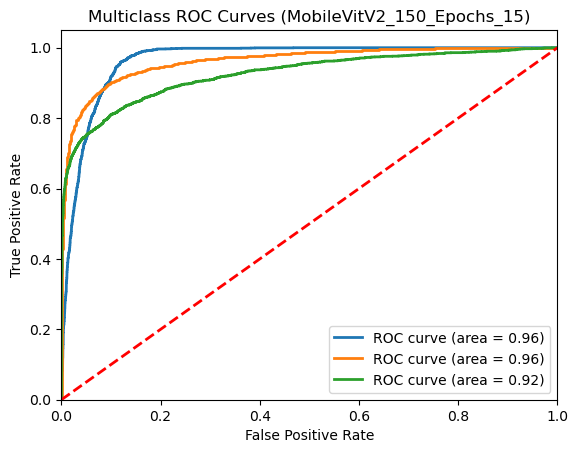

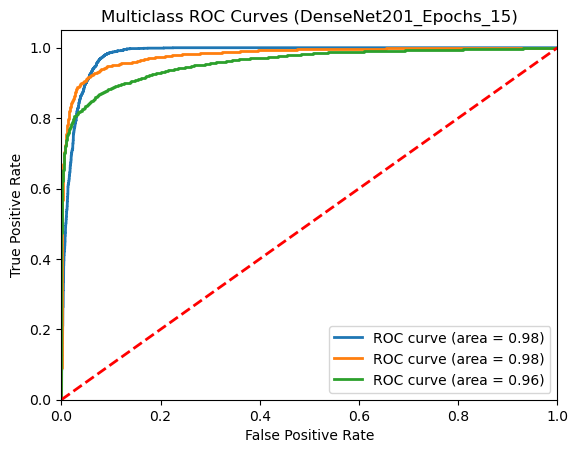

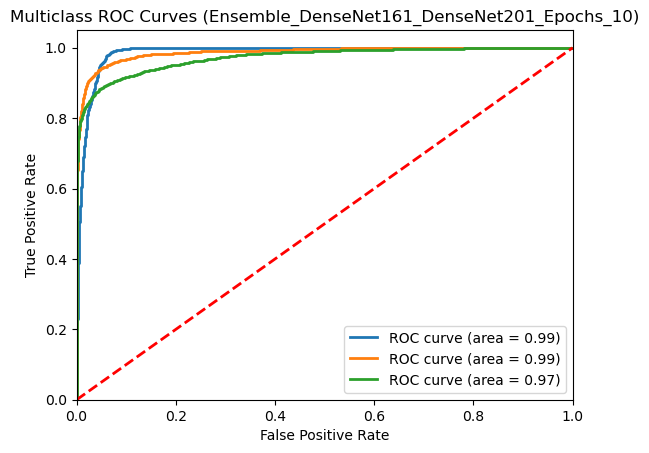

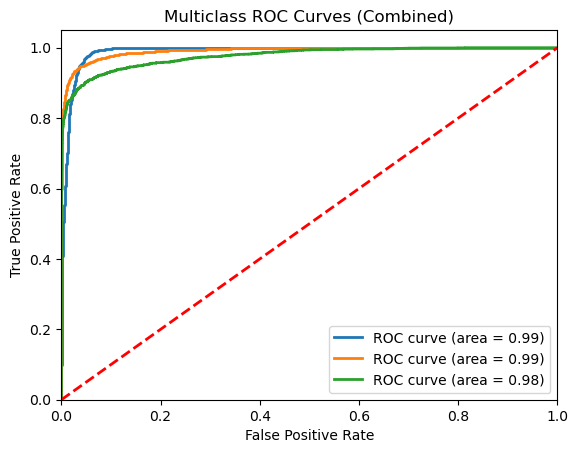

In [ ]:
def plot_auc_score_and_multiclass_roc_curves(y_test, y_pred_prob, model_name):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i], )
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    lw = 2
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curves ({model_name})')
    plt.legend(loc="lower right")
    plt.show()
    
plot_auc_score_and_multiclass_roc_curves(y_test1, y_pred_prob1, "DenseNet161_Epochs_2")
plot_auc_score_and_multiclass_roc_curves(y_test2, y_pred_prob2, "DenseNet161_Epochs_6")
plot_auc_score_and_multiclass_roc_curves(y_test3, y_pred_prob3, "DenseNet161_Epochs_15")
plot_auc_score_and_multiclass_roc_curves(y_test4, y_pred_prob4, "MobileVitV2_150_Epochs_15")
plot_auc_score_and_multiclass_roc_curves(y_test5, y_pred_prob5, "DenseNet201_Epochs_15")
plot_auc_score_and_multiclass_roc_curves(y_test6, y_pred_prob6, "Ensemble_DenseNet161_DenseNet201_Epochs_10")

combined_y_test = np.add(np.add(np.add(y_test1, y_test2), y_test3), np.add(np.add(y_test4, y_test5), y_test6)) / 6
combined_y_pred_prob = np.add(np.add(np.add(y_pred_prob1, y_pred_prob2), y_pred_prob3), np.add(np.add(y_pred_prob4, y_pred_prob5), y_pred_prob6)) / 6
plot_auc_score_and_multiclass_roc_curves(combined_y_test, combined_y_pred_prob, "Combined")

# 10. AUC Score for the trained models

In [ ]:
def get_auc_score(y_test, y_pred_prob, model_name):
    
    print(10 * "=", f"For {model_name}", 10 * "=")
    
    auc_ovo = roc_auc_score(y_test, y_pred_prob, multi_class="ovo")
    auc_ovr = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
    
    print('AUC (OVO): %.2f' % auc_ovo)
    print('AUC (OVR): %.2f' % auc_ovr)

get_auc_score(y_test1, y_pred_prob1, "DenseNet161_Epochs_2")
get_auc_score(y_test2, y_pred_prob2, "DenseNet161_Epochs_6")
get_auc_score(y_test3, y_pred_prob3, "DenseNet161_Epochs_15")
get_auc_score(y_test4, y_pred_prob4, "MobileVitV2_150_Epochs_15")
get_auc_score(y_test5, y_pred_prob5, "DenseNet201_Epochs_15")
get_auc_score(y_test6, y_pred_prob6, "Ensemble_DenseNet161_DenseNet201_Epochs_10")
get_auc_score(combined_y_test, combined_y_pred_prob, "Combined")

========== For DenseNet161_Epochs_2 ==========
AUC (OVO): 0.97
AUC (OVR): 0.97
========== For DenseNet161_Epochs_6 ==========
AUC (OVO): 0.97
AUC (OVR): 0.97
========== For DenseNet161_Epochs_15 ==========
AUC (OVO): 0.98
AUC (OVR): 0.98
========== For MobileVitV2_150_Epochs_15 ==========
AUC (OVO): 0.95
AUC (OVR): 0.95
========== For DenseNet201_Epochs_15 ==========
AUC (OVO): 0.97
AUC (OVR): 0.97
========== For Ensemble_DenseNet161_DenseNet201_Epochs_10 ==========
AUC (OVO): 0.98
AUC (OVR): 0.98
========== For Combined ==========
AUC (OVO): 0.99
AUC (OVR): 0.99


# 11. Conclusion

Since the dataset was sufficiently large (30k train & 7.5k val images), no augmentations were applied, thus saving GPU time and preventing any possible memory errors.

For this task the following models were trained:
- DenseNet161 (2 Epochs)
- DenseNet161 (6 Epochs)
- DenseNet161 (15 Epochs)
- MobileVitV2 (15 Epochs)
- DenseNet201 (15 Epochs)
- Ensemble of DenseNet161 and DenseNet201 (10 Epochs)

The final predictions of all the aforementioned models were **averaged** to achieve the best performace.

PS: *Models such as ResNet50 and InceptionResNetV2 were also trained, however due to sub-par performance, they were not used.*